In [1]:
# libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import scipy.cluster.hierarchy as spc
from statsmodels.stats.outliers_influence import variance_inflation_factor

#pandas option to show all columns 
pd.set_option('display.max.columns', None)

#global figure size for matplotlib
plt.rcParams['figure.figsize'] = (20, 10)

#global style for seaborn & plt
sns.set(style="whitegrid")

#import data
df = pd.read_csv('dataset.csv')

/Users/adames/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Replace missing data

In [2]:
def numerical_imputator(X_train:pd.DataFrame,col:str):
    X_train = X_train.copy()
    X_train[col] = X_train[col].fillna(X_train[col].median())
    return X_train

def categorical_imputator(X_train:pd.DataFrame,col:str):
    X_train = X_train.copy()
    X_train = X_train.replace('', np.nan)
    X_train[col] = X_train[col].fillna('None')
    return X_train

for i in df.select_dtypes(include=np.number).columns.tolist():
    df = numerical_imputator(X_train = df , col = i)

for i in df.select_dtypes(exclude=np.number).columns.tolist():
    df = categorical_imputator(X_train = df , col = i) 


### Categorical association : Cramér’s V

- Is a measure of association between two categorical features based on a nominal variation of Pearson’s Chi-Square Test.

- The output is in the range of [0,1], where 0 means no association and 1 is full association.

- It seems like Customer Category and Loan Sanctioned Status are associated.

In [3]:
def cramers_v(X:pd.Series, Y:pd.Series,rounding=2):
    x, y = X.copy(), Y.copy()
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return round(np.sqrt(phi2corr/min((kcorr-1),(rcorr-1))),rounding)

def categorical_correlation_matrix_C_V(df:pd.DataFrame):
    categorical_vars = list(df.select_dtypes(include = object).columns)
    row_var, col_var, correlation = [] , [] , []
    for i in categorical_vars:
        for j in categorical_vars:
            try:
                row_var.append(i) , col_var.append(j)
                correlation.append(cramers_v(X = df[i], Y = df[j]))
            except:
                row_var.append(i) , col_var.append(j)
                correlation.append(0)

    corr_matrix = pd.DataFrame({'Row var':row_var,'Col var':col_var,'Score':correlation})
    corr_matrix = pd.pivot(corr_matrix, index='Row var', columns='Col var', values='Score')
    corr_matrix.index.name , corr_matrix.T.index.name  = None , None
    return corr_matrix

cor_matrix_tri = categorical_correlation_matrix_C_V(df)
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

,Customer Category,Job,Loan Sanctioned Status,Purpose
Customer Category,1.000000,0.000000,0.770000,0.000000
Job,0.000000,1.000000,0.000000,0.160000
Loan Sanctioned Status,0.770000,0.000000,1.000000,0.060000
Purpose,0.000000,0.160000,0.060000,1.000000


### Categorical - Numerical association: Correlation Ratio
 - The Correlation Ratio answers the following question: Given a continuous number, how well can you know to which category it belongs to?

 - Just like the two coefficients we’ve seen before, here too the output is on the range of [0,1].

 - It seems that Customer Category is associated with Annual income and Loan Amount. Since Loan Sanctioned Status is associated with Customer Category, this variable is also associated with Annual income and Loan Amount, but the effect is more intense.

In [4]:
def correlation_ratio(categorical_var:pd.Series, numerical_var:pd.Series,rounding=2):
    categories , measurements = categorical_var.copy(), numerical_var.copy().astype(int)
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return round(eta,rounding)

def mixed_correlation_matrix(df:pd.DataFrame):
    categorical_vars = list(df.select_dtypes(include = object).columns)
    numerical_vars = list(df.select_dtypes(exclude = object).columns)
    row_var, col_var, correlation = [] , [] , []
    for i in categorical_vars:
        for j in numerical_vars:
            try:
                row_var.append(i) , col_var.append(j)
                correlation.append(correlation_ratio(categorical_var = df[i].values, numerical_var = df[j].values))
            except:
                row_var.append(i) , col_var.append(j)
                correlation.append(0)

    corr_matrix = pd.DataFrame({'Row var':row_var,'Col var':col_var,'Score':correlation})
    corr_matrix = pd.pivot(corr_matrix, index='Row var', columns='Col var', values='Score')
    corr_matrix.index.name , corr_matrix.T.index.name  = None , None
    return corr_matrix

# antes de remover imbalanced vars, check si son relevantes a la respuesta
cor_matrix_tri = mixed_correlation_matrix(df)
display(cor_matrix_tri.style.background_gradient(cmap='coolwarm'))

,Age_in_years,Annual income,Credit_amount,Customer Balance,Duration_in_months,Loan Amount,Target
Customer Category,0.060000,0.710000,0.050000,0.030000,0.050000,0.660000,0.060000
Job,0.160000,0.040000,0.340000,0.090000,0.220000,0.040000,0.040000
Loan Sanctioned Status,0.010000,0.920000,0.010000,0.010000,0.020000,0.850000,0.060000
Purpose,0.170000,0.110000,0.370000,0.070000,0.270000,0.120000,0.180000


### Spearman Correlation
 -  Spearman does not assumes linear relationship nor restricst ordinal variables.

 - In general, this coefficient (Pearson) can be interpreted as follows:

        Magnitudes:
        .00-.19 very weak
        .20-.39 weak
        .40-.59 moderate
        .60-.79 strong
        .80-1.0 very strong
        
        Sign:
        positive indicate a proportional relationship
        negative indicate a inverse proportional relationship

In [5]:
df_encoded = pd.get_dummies(df,drop_first=True).copy()
cor_matrix_tri = df_encoded.corr(method='spearman')
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

,Duration_in_months,Credit_amount,Age_in_years,Customer Balance,Loan Amount,Annual income,Target,Purpose_A41,Purpose_A410,Purpose_A42,Purpose_A43,Purpose_A44,Purpose_A45,Purpose_A46,Purpose_A48,Purpose_A49,Job_A172,Job_A173,Job_A174,Job_None,Loan Sanctioned Status_Yes,Customer Category_B,Customer Category_C,Customer Category_D
Duration_in_months,1.000000,0.624709,-0.035941,-0.023777,-0.038267,-0.015908,0.205685,0.175629,0.088939,-0.032291,-0.053277,-0.050600,-0.013147,-0.018129,-0.082363,0.162521,-0.193693,0.075691,0.142467,-0.027296,-0.022914,-0.036822,0.055194,-0.023360
Credit_amount,0.624709,1.000000,0.021219,-0.003477,0.003145,-0.005836,0.087083,0.285759,0.091530,0.054937,-0.174155,-0.095825,-0.040431,-0.040483,-0.106831,0.119540,-0.190633,-0.015204,0.269134,-0.039597,-0.003887,0.000223,0.007185,-0.006730
Age_in_years,-0.035941,0.021219,1.000000,0.049171,0.011414,0.006842,-0.119907,0.043002,0.049770,-0.124999,-0.051629,-0.025530,0.018313,0.069570,0.010955,-0.002694,0.050210,-0.147945,0.135306,0.015050,0.011580,-0.030350,0.010696,-0.017319
Customer Balance,-0.023777,-0.003477,0.049171,1.000000,-0.003135,-0.001869,-0.007408,-0.033386,0.009862,-0.014971,0.033603,0.011994,-0.046689,0.008496,0.000569,0.031521,0.039917,-0.060492,0.049011,-0.062013,-0.006422,-0.020694,0.002209,0.026822
Loan Amount,-0.038267,0.003145,0.011414,-0.003135,1.000000,0.804072,-0.077293,-0.003771,0.001343,-0.006613,0.002120,0.019624,0.006615,-0.070244,0.055682,-0.056026,-0.003186,-0.000271,-0.011456,-0.001333,0.925820,0.433839,-0.140873,-0.544501
Annual income,-0.015908,-0.005836,0.006842,-0.001869,0.804072,1.000000,-0.051808,-0.018816,-0.042218,-0.000229,0.015280,0.059779,0.009848,-0.072320,0.033507,-0.027061,0.022099,-0.001616,-0.028490,-0.015186,0.866026,0.423662,-0.132403,-0.499469
Target,0.205685,0.087083,-0.119907,-0.007408,-0.077293,-0.051808,1.000000,-0.099791,0.028058,0.020971,-0.106922,0.008016,0.020828,0.070088,-0.039281,0.036129,-0.020223,-0.014416,0.040559,-0.002617,-0.056737,-0.016045,0.046897,-0.000499
Purpose_A41,0.175629,0.285759,0.043002,-0.033386,-0.003771,-0.018816,-0.099791,1.000000,-0.037345,-0.159301,-0.211317,-0.037345,-0.050823,-0.077740,-0.032293,-0.111062,-0.111219,-0.029016,0.183035,-0.028451,-0.016450,0.007533,0.012980,-0.026132
Purpose_A410,0.088939,0.091530,0.049770,0.009862,0.001343,-0.042218,0.028058,-0.037345,1.000000,-0.051810,-0.068727,-0.012146,-0.016529,-0.025283,-0.010503,-0.036121,-0.031928,-0.123014,0.186835,-0.009253,-0.018368,-0.026817,0.036942,-0.001765
Purpose_A42,-0.032291,0.054937,-0.124999,-0.014971,-0.006613,-0.000229,0.020971,-0.159301,-0.051810,1.000000,-0.293164,-0.051810,-0.070508,-0.107850,-0.044800,-0.154078,-0.019640,0.064645,-0.042335,-0.008318,-0.007792,0.000982,-0.013997,0.020702


### Converting the correlation matrix into a distance matrix and then into a dendrogram

- for this step, the correlation matrix is converted into a distance matrix using the following calculation : 1 - correlation matrix

- this allows for a interval of values between 0 and 2. 

- At a distance of 2 the groups undifferentiated

- At distance 0, each variable represents a cluster.

- Each cluster holds correlated variables. 

Cutoff at:  0.82


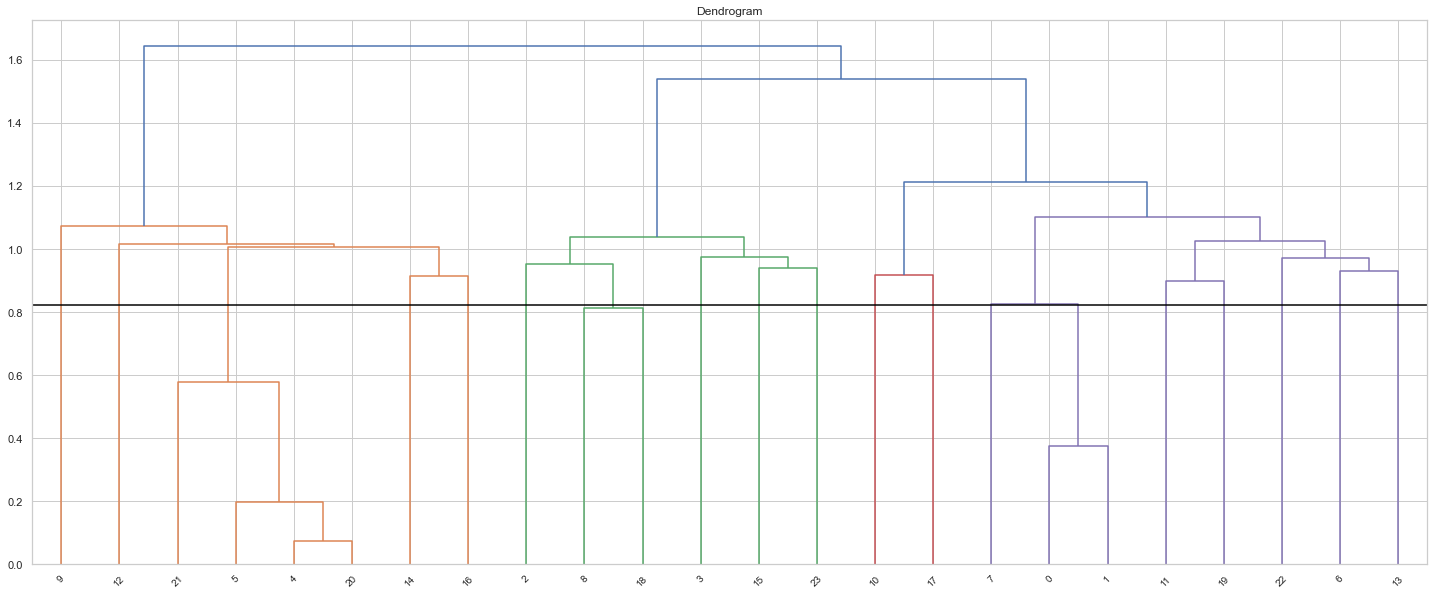

In [6]:
# Creating a distance matrix from correlation matrix
pdist_uncondensed = 1.0 - cor_matrix_tri.to_numpy()
pdist_condensed = np.concatenate([row[i+1:] for i, row in enumerate(pdist_uncondensed)])
cutoff = round(0.5 * pdist_condensed.max(),2)
linkage = spc.linkage(pdist_condensed, method='complete')
idx = spc.fcluster(linkage, cutoff, 'distance')

#Dendrogram plot
plt.figure(figsize=(25, 10))  
plt.title("Dendrogram")  
spc.dendrogram(linkage)
plt.axhline(y=cutoff, color='black', linestyle='-');
print('Cutoff at: ', cutoff)

### Using VIF within clusters to remove multicolinear variables.

In [7]:
# compute the vif for all given features
def compute_vif(df,considered_features):
    """a VIF greater or equal to 5 will be deemed to be too large."""
    X = df[considered_features].copy()
    
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

# cluster insider dist matrix
distances_per_groups = cor_matrix_tri.where(np.triu(np.ones(df_encoded.corr(method='spearman').shape)).astype(bool)).copy()
distances_per_groups['Cluster'] = idx

# nested loop for multicolinearity removal 
to_drop = []
simulator = df_encoded.copy()
for k in list(distances_per_groups['Cluster'].unique()):
    temp = distances_per_groups[distances_per_groups['Cluster'] == k][distances_per_groups[distances_per_groups['Cluster'] == k].index.to_list()].copy()
    features = list(temp.index)
    counter = len(list(temp.index))*2
    while counter >0:
        vifs = compute_vif(df = simulator, considered_features = features).sort_values('VIF', ascending=False).reset_index(drop=True)
        if vifs.loc[0,'VIF'] >=5:
            to_drop.append(vifs.loc[0,'Variable'])
            features.remove(vifs.loc[0,'Variable'])
            simulator = simulator.drop(columns = to_drop[-1]).copy()
        counter -= 1

# drop vars
to_drop

['Loan Sanctioned Status_Yes']

### Results:
- From this clustering exercise, it seems that the variable "Loan Sanctioned Status" was a redundant one and should be removed.